In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#1967 onwards with skaters with >100 GP
master_df = pd.read_csv('tt_filt67_100GP_file.csv')
master_df.head()

,Player,GP,G,A,TP,PPG,PIM,POS,firstYear,lastYear,Awards,Cups,All-Star Games,HoF
0,Wayne Gretzky,1487,894,1963,2857,1.921,577,1,1979,1999,26,4,18,1
1,Mark Messier,1756,694,1193,1887,1.075,1910,1,1979,2004,5,6,15,1
2,Gordie Howe,1767,801,1049,1850,1.047,1685,1,1946,1980,12,4,23,1
3,Ron Francis,1731,549,1249,1798,1.039,979,1,1981,2004,0,2,4,1
4,Marcel Dionne,1348,731,1040,1771,1.314,600,1,1971,1989,3,0,8,1


In [3]:
master_df.columns

Index(['Player', 'GP', 'G', 'A', 'TP', 'PPG', 'PIM', 'POS', 'firstYear',
       'lastYear', 'Awards', 'Cups', 'All-Star Games', 'HoF'],
      dtype='object')

In [4]:
#Add members to HoF who were inducted after 2011
new_hof = ['Jarome Iginla', 'Marian Hossa','Martin St. Louis','Teemu Selanne','Nicklas Lidstrom','Chris Pronger','Mark Recchi','Mike Modano','Peter Forsberg']

['Jarome Iginla',
 'Marian Hossa',
 'Martin St. Louis',
 'Teemu Selanne',
 'Nicklas Lidstrom',
 'Chris Pronger',
 'Mark Recchi',
 'Mike Modano',
 'Peter Forsberg']

In [5]:
#drop hof additions since 2011 for testing purposes
inverse_boolean_series = ~master_df.Player.isin(new_hof)
retired_players = master_df[inverse_boolean_series]

#filter retired players with 100 or more games played
retired_players = retired_players[retired_players['GP']>=100]

#create df with only new hof additions for testing
boolean_series = master_df.Player.isin(new_hof)
new_hof_df = master_df[boolean_series]

initial_eligible_players = pd.read_csv('predict_file.csv')

#isolate any 'active' hof in the eligible players dataset
active_hof = initial_eligible_players[initial_eligible_players['HoF'] == 1]

#append any 'active' hof players to the test set
new_hof_df = new_hof_df.append(active_hof)

#update the eligible players df
eligible_players = initial_eligible_players[initial_eligible_players['HoF'] == 0]


In [6]:
#List the columns we do not want to include in the model
cols_to_drop = ['Player','firstYear', 'lastYear', 'HoF']

In [8]:
target = 'HoF'
y = retired_players[target]
X = retired_players.drop(cols_to_drop, axis=1)

In [9]:
from sklearn.model_selection import train_test_split

#Train/test split, because I have a small imbalanced dataset I made sure to stratify my data
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.9605


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [12]:
np.random.seed(42)

In [13]:
# Increasing hyperparameter C increases the accuracy score

log_model = make_pipeline(
       StandardScaler(),
       LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 50)
)

log_model.fit(X_train, y_train);

In [14]:
print('LOG: Training Accuracy Score:', log_model.score(X_train, y_train))
print('LOG: Validation Accuracy Score:', log_model.score(X_val, y_val))

LOG: Training Accuracy Score: 0.9845
LOG: Validation Accuracy Score: 0.99


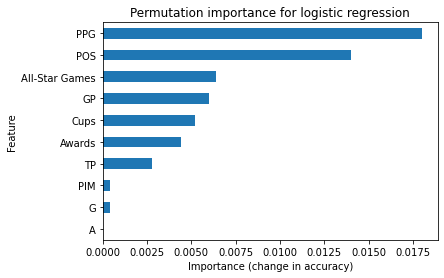

In [15]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(log_model, X_val, y_val, n_jobs=-1, random_state=42)

data = {'mean_importance' : perm_imp['importances_mean'], 'std_importances' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('mean_importance', ascending=True, inplace=True)

df['mean_importance'].tail(15).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for logistic regression');

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
forest_model = RandomForestClassifier(n_estimators=15)

forest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=15)

In [18]:
print('FOREST: Training Accuracy:', forest_model.score(X_train, y_train))
print('FOREST: VAl Accuracy:', forest_model.score(X_val, y_val))

FOREST: Training Accuracy: 1.0
FOREST: VAl Accuracy: 0.984


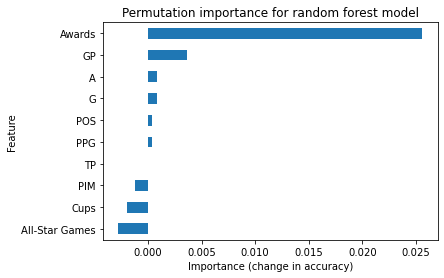

In [19]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(forest_model, X_val, y_val, n_jobs=-1, random_state=42)

data = {'mean_importance' : perm_imp['importances_mean'], 'std_importances' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('mean_importance', ascending=True, inplace=True)

df['mean_importance'].tail(15).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for random forest model');

In [20]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [21]:
boost_model = XGBClassifier(n_jobs=-1, random_state=42, n_estimators= 500, max_depth= 2, eta= 0.3, colsample_bytree= 0.6)

boost_model.fit(X_train, y_train);

[11:49:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Y243863\Anaconda3\envs\bcs\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [22]:
print('BOOST: Training accuracy:', boost_model.score(X_train, y_train))
print('BOOST: Val accuracy:', boost_model.score(X_val, y_val))

BOOST: Training accuracy: 1.0
BOOST: Val accuracy: 0.982


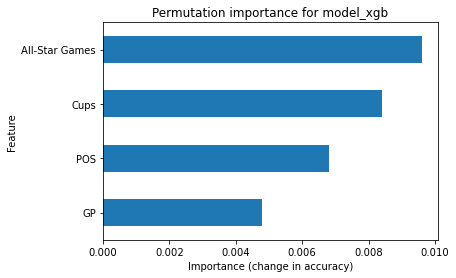

In [23]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(boost_model, X_val, y_val, n_jobs=-1, random_state=42)

data = {'mean_importance' : perm_imp['importances_mean'], 'std_importances' : perm_imp['importances_std']}

df = pd.DataFrame(data, index=X_val.columns)
df.sort_values('mean_importance', ascending=True, inplace=True)

df['mean_importance'].tail(4).plot(kind='barh')
plt.xlabel('Importance (change in accuracy)')
plt.ylabel('Feature')
plt.title('Permutation importance for model_xgb');

In [24]:
from sklearn.metrics import plot_roc_curve

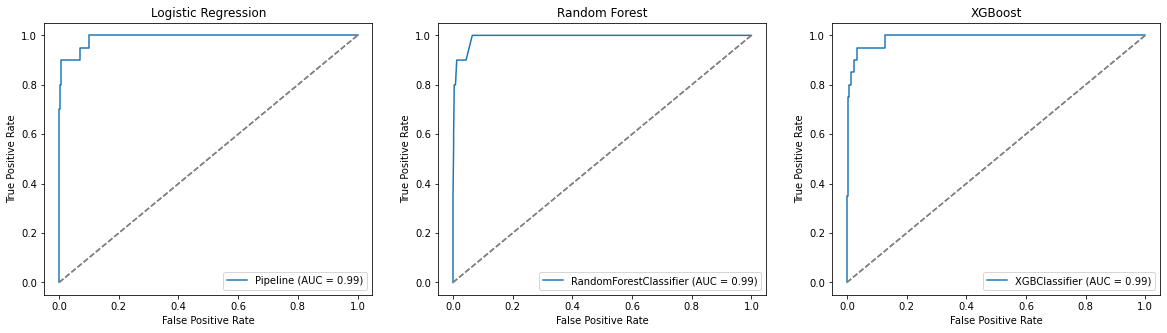

In [25]:
#Compare the 3 models and print results
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,5))

plot_roc_curve(log_model, X_val, y_val, ax=ax1)
plot_roc_curve(forest_model, X_val, y_val, ax=ax2)
plot_roc_curve(boost_model, X_val, y_val, ax=ax3)

ax1.plot([(0,0), (1,1)], color='grey', linestyle='--')
ax2.plot([(0,0), (1,1)], color='grey', linestyle='--')
ax3.plot([(0,0), (1,1)], color='grey', linestyle='--')


ax1.set_title('Logistic Regression')
ax2.set_title('Random Forest')
ax3.set_title('XGBoost')

plt.show()

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

In [27]:
xgboost_model1 = XGBClassifier()

param_space = {
         "max_depth": [1, 2, 3, 4],
         "eta": [0.3, 0.2, 0.1, 0.05, 0.01],
         "n_estimators": [100, 200, 300, 400, 500],
         "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1]
 }

xgboost_rand_search = RandomizedSearchCV(xgboost_model1, param_distributions=param_space, n_iter=20,
                                         scoring="accuracy", verbose=True, cv=StratifiedKFold(n_splits=5),
                                         n_jobs=-1, random_state=42)

xgboost_rand_search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.4s


[11:49:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.1s finished
C:\Users\Y243863\Anaconda3\envs\bcs\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=No...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=None,
                                           subsample=None, tree_

In [28]:
xgboost_rand_search.best_params_

{'n_estimators': 100, 'max_depth': 3, 'eta': 0.2, 'colsample_bytree': 0.5}

In [29]:
xgboost_rand_search.best_score_

0.818

In [30]:
from scipy.stats import uniform, truncnorm, randint
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199)
}

In [52]:
rf_model1 = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
forest_rand_search = RandomizedSearchCV(rf_model1, model_params, n_iter=100, cv=5, random_state=42)

# train the random search meta-estimator to find the best model out of 500 candidates
forest_rand_search.fit(X, y)

# print winning set of hyperparameters
forest_rand_search.best_score_


0.8428000000000001

In [32]:
#******UNCOMMENT SECTION TO ONLY USE ACTIVE PLAYERS******

# cols_to_drop = ['firstYear','POS', 'lastYear', 'HoF']
# # target = 'HoF'
# # eligible_players.reset_index(drop=True)
# # eligible_players.set_index('Player')
# # eligible_players.head()
# X_test = eligible_players.drop(cols_to_drop, axis=1)
# X_test.set_index('Player', inplace=True)
# # X_test.set_index('Player')
# y_pred = clf.predict(X_test)

# results = pd.DataFrame(y_pred, columns=['HoF'], index=X_test.index)


In [33]:
model = xgboost_rand_search.fit(X, y)

#Use this cell for ALL players regardless of active status or GP
master_df = pd.read_csv('master_stats_file.csv')

cols_to_drop = ['firstYear', 'lastYear', 'HoF']
X_test = master_df.drop(cols_to_drop, axis=1)
X_test.set_index('Player', inplace=True)
# X_test.set_index('Player')
y_pred = model.predict(X_test)

results = pd.DataFrame(y_pred, columns=['HoF'], index=X_test.index)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s


[11:52:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.7s finished
C:\Users\Y243863\Anaconda3\envs\bcs\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [34]:
# Players the model predicts will be the next to enter the HOF

results[results['HoF'] == 1]

,HoF
Player,
Wayne Gretzky,1
Jaromir Jagr,1
Mark Messier,1
Gordie Howe,1
Ron Francis,1
...,...
Sergei Makarov,1
Marcel Pronovost,1
Rod Langway,1


In [35]:
import shap

0.04

                  hof
Player               
Wayne Gretzky       1
Jaromir Jagr        1
Mark Messier        1
Gordie Howe         1
Ron Francis         1
...               ...
Jonathan Aspirot    0
Drew O'Connor       0
Jake Neighbours     0
Philip Tomasino     0
Connor McMichael    0

[7234 rows x 1 columns]


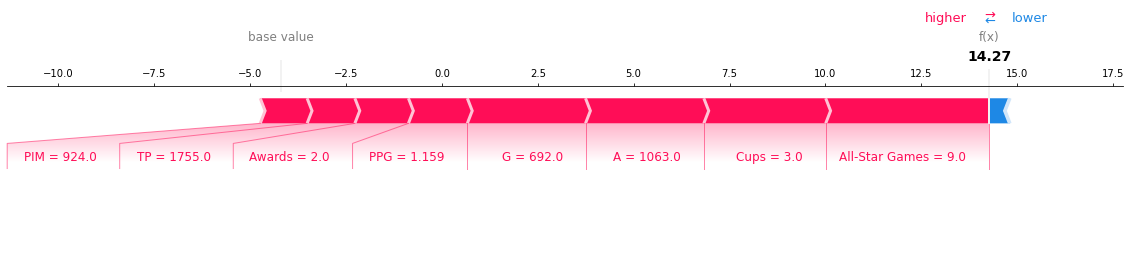

In [40]:
X_test = master_df.drop(cols_to_drop, axis=1)
X_test.set_index('Player', inplace=True)


y_pred = boost_model.predict(X_test)

results = pd.DataFrame(y_pred, columns=['hof'], index=X_test.index)

####Chose Player to run Shap.force visual on####
player = "Steve Yzerman"

#Determines which record to use
row = X_test[X_test.index == player]

explainer = shap.TreeExplainer(boost_model)

shap_values = explainer.shap_values(row)


shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    matplotlib=True
)

#***Code to save as html file***
#***Could not figure out how to save as PNG since visual is displayed using javascript***
# f = shap.force_plot(
#     base_value=explainer.expected_value,
#     shap_values=shap_values,
#     features=row,
#     matplotlib=False,
#     show=True
# )
# shap.save_html(player + ".html", f)



In [ ]:
#****UNCOMMENT TO CREATE DATAFRAME AND CSVs****

# shap_values = explainer.shap_values(X)
# shap_values = explainer.shap_values(X_test)

# new_df = pd.concat([master_df, pd.DataFrame(shap_values, 
#            columns='shap_'+ X.columns.values)], axis=1)
# base_val = explainer.expected_value.mean()


# new_df.head()

# #create master stats file with FINAL VALUE (base value + SUM(shap_values))

# new_df['BaseValue']= -4.187
# new_df['FinalValue']= new_df["shap_G"] + new_df["shap_A"] + new_df["shap_TP"] +  new_df["shap_PPG"] + new_df["shap_PIM"]  + new_df["shap_POS"]  + new_df["shap_Awards"]+ new_df["shap_Cups"]+ new_df["shap_All-Star Games"]+ new_df["BaseValue"]
# new_df.head()

###CONVERT SHAP VALUES TO PROBABILITIES (ONLY VALID FOR XGBOOST MODEL)

# new_df['HoF_Probability'] = np.exp(new_df['FinalValue'])/(1+np.exp(new_df['FinalValue']))

# cols_to_drop1 = ['shap_GP', 'shap_G', 'shap_A', 'shap_TP', 'shap_PPG', 'shap_PIM',
#        'shap_POS', 'shap_Awards', 'shap_Cups', 'shap_All-Star Games', 'BaseValue']
# cols_to_drop1
# final_df = new_df.drop(cols_to_drop1, axis=1)

# final_df.head()
# new_df.to_csv('shap_values.csv', index=False, header=True, encoding='utf-8-sig')
# final_df.to_csv('master_stats_file_final_values.csv', index=False, header=True, encoding='utf-8-sig')

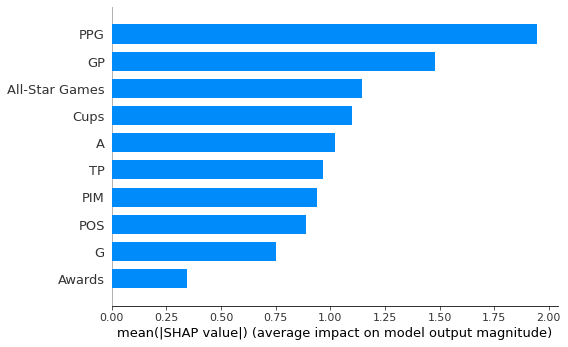

In [42]:
#BUILD SUMMARY PLOT###
shap_values = shap.TreeExplainer(boost_model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [50]:
shap_values = shap.TreeExplainer(boost_model).shap_values(X_train)

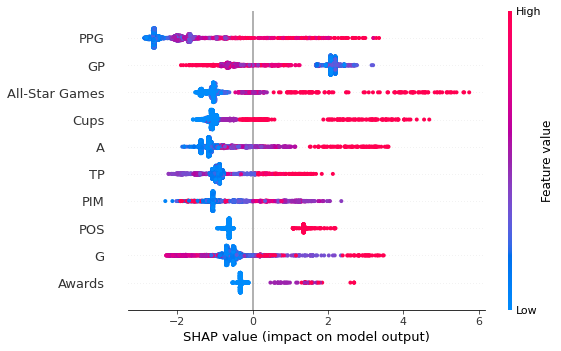

In [51]:
###CREATE SHAPLEY SUMMARY PLOT###
shap.summary_plot(shap_values, X_train)